In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.vision import *
from pathlib import Path
from skimage.io import imread,imsave,imshow
import warnings
from collections import defaultdict
import pandas as pd

In [1]:
from tqdm import tqdm_notebook as tqdm
import os
import gc
import torch
import matplotlib.pyplot as plt

In [44]:
_ = torch.randn(5,3);
_

tensor([[ 2.4761,  0.0638, -1.7845],
        [ 1.0708,  1.9330,  0.0233],
        [-0.0164, -0.4356, -0.1148],
        [ 0.0425, -1.0772, -1.4325],
        [ 1.3624, -0.3647, -1.1976]])

In [45]:
p_ = _.argmax(-1)
p_

tensor([0, 1, 0, 0, 0])

In [46]:
x = torch.arange(0, 3);
x

tensor([0, 1, 2])

In [47]:
x[:,None]

tensor([[0],
        [1],
        [2]])

In [48]:
p_==x[:, None]

tensor([[1, 0, 1, 1, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.uint8)

In [53]:
targs = torch.tensor([0,1,2,2,1]);
targs

tensor([0, 1, 2, 2, 1])

In [54]:
targs==x[:, None, None]

tensor([[[1, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 1]],

        [[0, 0, 1, 1, 0]]], dtype=torch.uint8)

In [55]:
from sklearn.metrics import recall_score

In [ ]:
np

In [62]:
recall_score(np.array([0,1,2,1,3]),np.array([0,0,1,2,3]),average="macro")

0.5

In [4]:
def clean_instance():
    gc.collect()
    torch.cuda.empty_cache()

In [5]:
clean_instance()

In [6]:
os.sched_getaffinity(0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [7]:
os.cpu_count()

16

In [8]:
from fastai.callbacks import *
from torchvision.models import *
from mxresnet import *
from functools import partial
from ranger import *

Mish activation loaded...


In [9]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [10]:
[torch.tensor([127.0,127.0,127.0]),torch.tensor([255.0,255.0,255.0])]

[tensor([127., 127., 127.]), tensor([255., 255., 255.])]

In [11]:
!ls ../data/imgs

models	train_0  train_1  train_2  train_3


In [12]:
img_dat_pth = Path('../data/imgs/train_0')

In [13]:
trn_df = pd.read_csv("../data/train.csv",index_col="image_id")

In [14]:
trn_df.nunique()

grapheme_root           168
vowel_diacritic          11
consonant_diacritic       7
grapheme               1295
dtype: int64

In [15]:
trn_df.head(5)

,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
image_id,,,,
Train_0,15,9,5,ক্ট্রো
Train_1,159,0,0,হ
Train_2,22,3,5,খ্রী
Train_3,53,2,2,র্টি
Train_4,71,9,5,থ্রো


In [16]:
trn_df.iloc[:5,[0,1,2]]

,grapheme_root,vowel_diacritic,consonant_diacritic
image_id,,,
Train_0,15,9,5
Train_1,159,0,0
Train_2,22,3,5
Train_3,53,2,2
Train_4,71,9,5


In [17]:
a = trn_df.loc['Train_0'].values

In [18]:
def lbl_from_img_pth(pth):
    #get fn from path
    #idex into df and get values
    fn = pth.stem
    _ = trn_df.loc[fn].values
    return _[1].astype(np.long)

In [19]:
tfms = get_transforms(flip_vert=False, do_flip=False,max_lighting=0.1, max_zoom=1.05, max_warp=0.1)

In [20]:
array([1,2,3],dtype=object)

array([1, 2, 3], dtype=object)

In [21]:
# what loss function
data = (ImageList.from_folder(img_dat_pth)
        .use_partial_data(0.06)
       .split_by_rand_pct()
       .label_from_func(lbl_from_img_pth)
       .transform(tfms,size=(137,236))
       .databunch(bs=32))

In [22]:
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

In [23]:
opt_func = partial(Ranger,  betas=(0.9,0.99), eps=1e-6)

In [24]:
arch = models.resnet34

In [25]:
learn = cnn_learner(data,arch,metrics=[accuracy,Recall(average='macro')],opt_func=opt_func)

Using Ranger Optimizer...


In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,recall,time


> /home/ravi/Documents/fastai/fastai/fastai/basic_train.py(28)loss_batch()
-> out = model(*xb)
(Pdb) s
--Call--
> /home/ravi/miniconda3/envs/fastpy3/lib/python3.7/site-packages/torch/nn/modules/module.py(487)__call__()
-> def __call__(self, *input, **kwargs):
(Pdb) c
> /home/ravi/Documents/fastai/fastai/fastai/basic_train.py(28)loss_batch()
-> out = model(*xb)
(Pdb) c
> /home/ravi/Documents/fastai/fastai/fastai/basic_train.py(28)loss_batch()
-> out = model(*xb)
(Pdb) c
> /home/ravi/Documents/fastai/fastai/fastai/basic_train.py(28)loss_batch()
-> out = model(*xb)
(Pdb) q
set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


BdbQuit: 

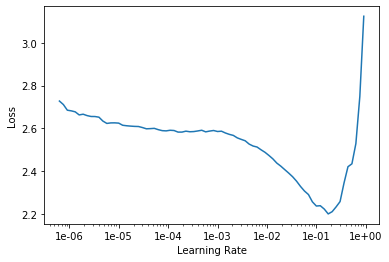

In [25]:
learn.recorder.plot()

In [27]:
fit_with_annealing(learn, 6, 0.01)

epoch,train_loss,valid_loss,accuracy,recall,time
0,0.567142,0.445001,0.852121,0.770434,01:21
1,0.430815,0.530174,0.829317,0.747887,01:29
2,0.398259,0.408917,0.873133,0.812527,01:32
3,0.361556,0.713420,0.777236,0.796493,01:34
4,0.304708,0.275901,0.905596,0.863588,01:35
5,0.240631,0.211155,0.931189,0.894826,01:36


In [28]:
learn.unfreeze()

Using Ranger Optimizer...


In [29]:
learn.lr_find()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


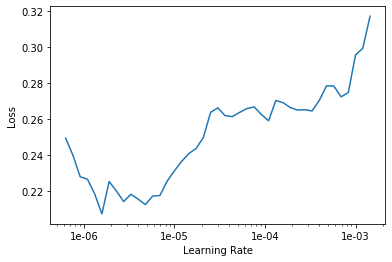

In [30]:
learn.recorder.plot()

In [31]:
fit_with_annealing(learn, 4, 0.0001)

epoch,train_loss,valid_loss,accuracy,recall,time
0,0.279955,0.215812,0.927405,0.900996,02:07
1,0.240814,0.172857,0.945728,0.920958,02:17
2,0.187900,0.157002,0.948218,0.924682,02:18
3,0.139292,0.115807,0.962856,0.946486,02:21


In [35]:
learn.save("ok")

In [36]:
learn.unfreeze()

Using Ranger Optimizer...


In [37]:
learn.lr_find()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


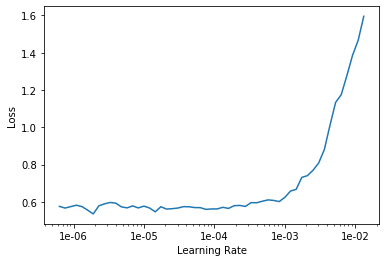

In [38]:
learn.recorder.plot()

In [39]:
fit_with_annealing(learn, 10, 0.0006)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.768925,0.536546,0.847740,nan,0.779500,02:07
1,0.546688,0.442426,0.872834,nan,0.819751,02:18
2,0.490221,0.406650,0.884585,nan,0.841879,02:19
3,0.431803,0.357101,0.900817,nan,0.852542,02:21
4,0.352009,0.341387,0.904202,0.893200,0.877682,02:21
5,0.347843,0.318720,0.910775,0.905240,0.885337,02:22
6,0.320011,0.302171,0.917048,0.918674,0.883354,02:23


In [41]:
_=learn.data.train_ds[0]

In [42]:
_[1]

Category 113

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.996158,0.767309,0.779825,nan,0.710365,01:36
1,1.169110,0.808509,0.764390,nan,0.685673,01:43


In [20]:
learn.load("first");

In [21]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


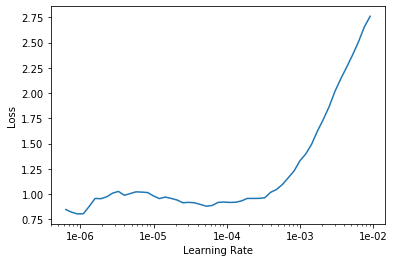

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.946862,0.534821,0.839275,nan,0.783138,02:15
1,0.692943,0.529973,0.843059,nan,0.764495,02:30
2,0.627683,0.427042,0.879805,nan,0.835934,02:36
3,0.491297,0.360214,0.895140,0.898221,0.859232,02:39
4,0.358056,0.308228,0.913463,0.904110,0.887363,02:43
5,0.291385,0.260808,0.926210,0.914889,0.906696,02:45
6,0.206432,0.253462,0.928998,0.921904,0.913160,02:51
7,0.177174,0.235944,0.938857,0.929264,0.925235,02:47
8,0.103325,0.227941,0.941346,0.939745,0.923167,02:47
9,0.074814,0.226603,0.942043,0.938843,0.924453,02:47


/home/ravi/Documents/fastai_v2_repo/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [ ]:
#check model, it is not what is expected